In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# some multhithreading magic
import tensorflow as tf
import multiprocessing as mp

from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.datasets import cifar10
from keras.callbacks import TensorBoard

# some shape magic
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

from IPython.display import SVG
from keras_sequential_ascii import sequential_model_to_ascii_printout

sns.set()

/home/valentin/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = 10
epochs = 10
batch_size = 128

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

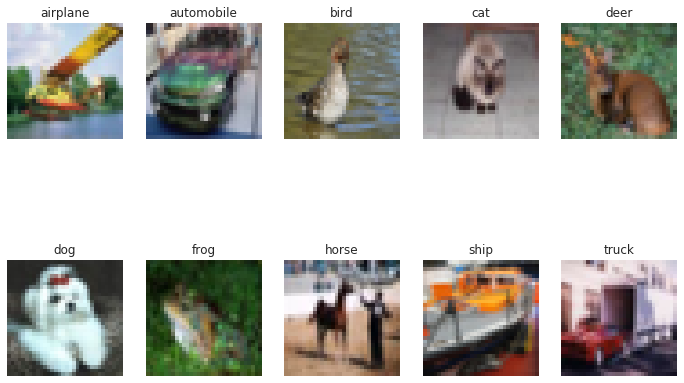

In [4]:
fig = plt.figure(figsize=(12,8))

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(1,2,0))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [5]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

In [6]:
def train(model, batch_size, epochs):
    history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/cifar_cnn')])
    return history

def my_eval(model, history):
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    plt.figure(0)
    plt.plot(history.history['acc'],'r')
    plt.plot(history.history['val_acc'],'g')
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['train','validation'])

    plt.figure(1)
    plt.plot(history.history['loss'],'r')
    plt.plot(history.history['val_loss'],'g')
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.legend(['train','validation'])

    plt.show()
    
def nn(model, batch_size=batch_size, epochs=epochs, save=None):
    
    model.summary()
    sequential_model_to_ascii_printout(model)
    
    history = train(model, batch_size, epochs)
    
    my_eval(model, history)
    
    if(save != None):
        model.save(save)
    

In [7]:
x_train[1,:].shape

(3, 32, 32)

In [8]:
def model_base():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_train[1,:].shape)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

In [9]:
model_base().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 30, 30)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 15, 15)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 13, 13)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 6, 6)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 6, 6)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 4, 4)         73856     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 30, 30)        896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 15, 15)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 13, 13)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 6, 6)          0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 64, 6, 6)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 4, 4)         73856     
__________

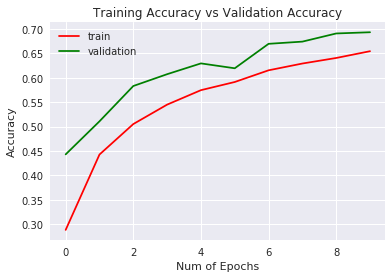

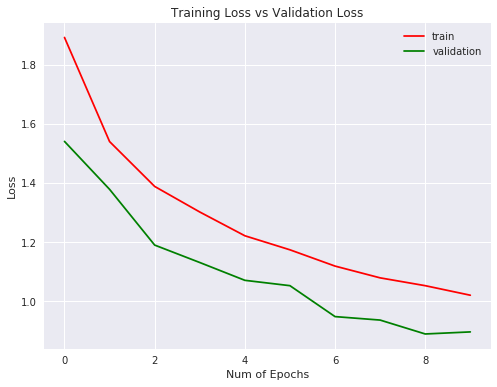

In [33]:
base = nn(model_base(), save='cifar_cnn_base.h5')

In [34]:
del base

In [10]:
from keras.models import load_model

base = load_model('cifar_cnn_base.h5')
base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 30, 30)        896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 15, 15)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 13, 13)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 6, 6)          0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 64, 6, 6)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 4, 4)         73856     
__________

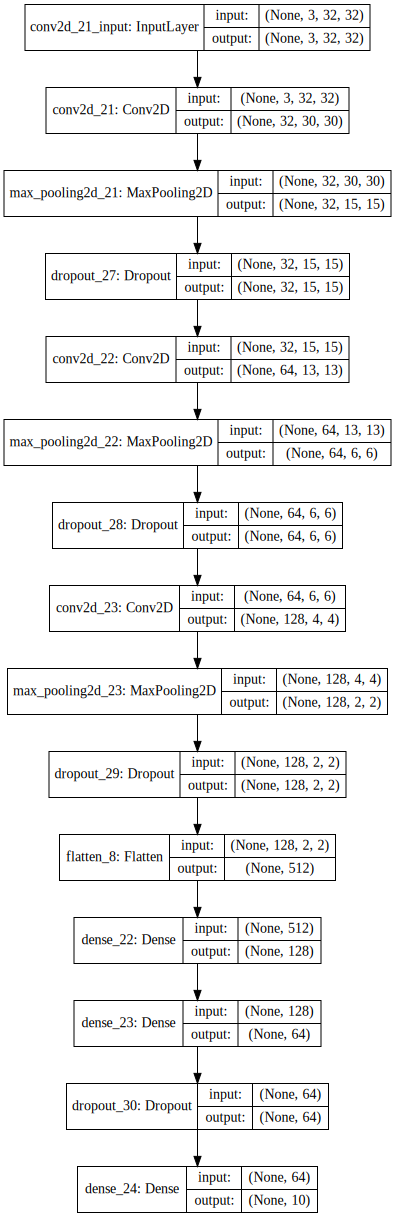

In [11]:
SVG(model_to_dot(base, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg',))

In [12]:
sequential_model_to_ascii_printout(base)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####      3   32   32
              Conv2D    \|/  -------------------       896     0.5%
                relu   #####     32   30   30
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     32   15   15
             Dropout    | || -------------------         0     0.0%
                       #####     32   15   15
              Conv2D    \|/  -------------------     18496    11.0%
                relu   #####     64   13   13
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     64    6    6
             Dropout    | || -------------------         0     0.0%
                       #####     64    6    6
              Conv2D    \|/  -------------------     73856    44.0%
                relu   #####    128    4    4
        MaxPooling2D   Y max -------------------         0     0.0%
              

In [13]:
def model_padded():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(x_train[1,:].shape)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 16, 16)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 16, 16)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 8, 8)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 64, 8, 8)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 8, 8)         73856     
__________

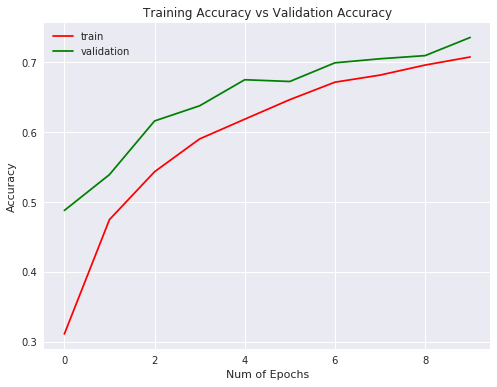

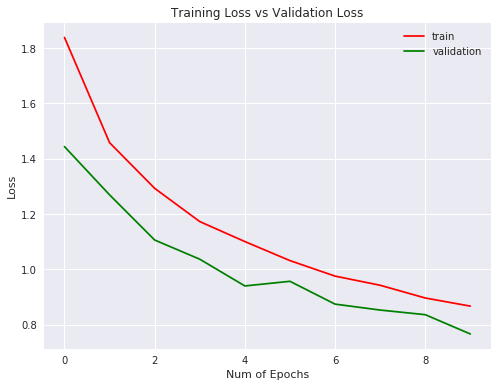

In [26]:
padded_model = nn(model_padded(), save='cifar_cnn_padded.h5')

In [15]:
def model_3():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(x_train[1,:].shape)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 30, 30)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 15, 15)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 15, 15)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 13, 13)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 6, 6)          0         
__________

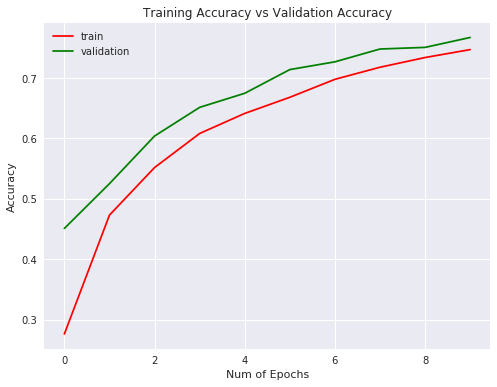

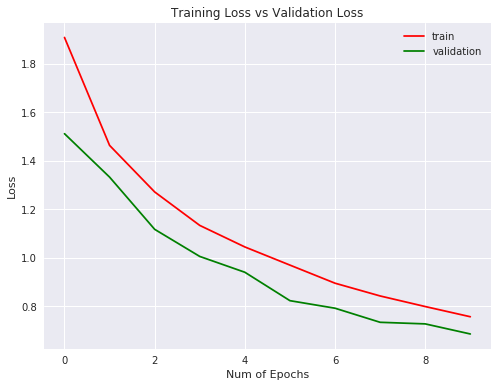

In [27]:
model3 = nn(model_3(), save='cifar_cnn_3.h5')

In [41]:
def model_deeper():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(x_train[1,:].shape)))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

In [43]:
model_deeper().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 16, 32, 32)        448       
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 16, 32, 32)        2320      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 32, 16, 16)        4640      
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 32, 16, 16)        9248      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 32, 8, 8)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 16, 32, 32)        448       
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 16, 32, 32)        2320      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 32, 16, 16)        4640      
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 32, 16, 16)        9248      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 32, 8, 8)          0         
__________

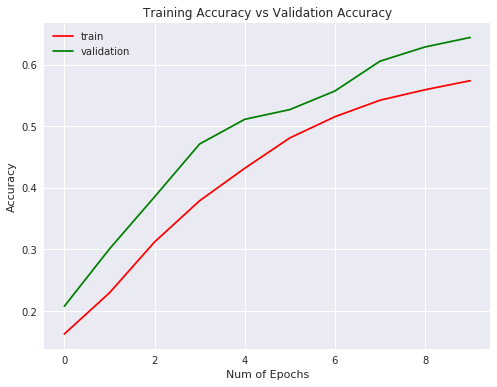

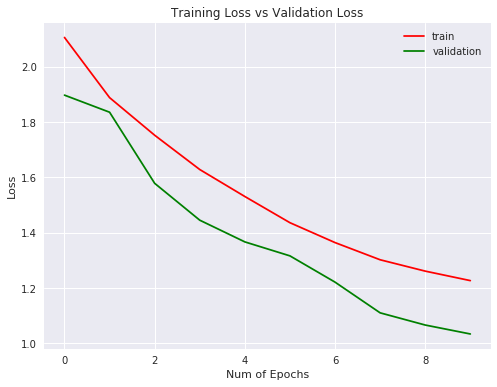

In [44]:
model_d = nn(model_deeper(), save='cifar_cnn_deeper.h5')

In [45]:
from keras.layers.convolutional import AveragePooling2D
def model_3_avg():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(x_train[1,:].shape)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 32, 30, 30)        9248      
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 15, 15)        0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 64, 15, 15)        18496     
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 64, 13, 13)        36928     
_________________________________________________________________
average_pooling2d_2 (Average (None, 64, 6, 6)          0         
__________

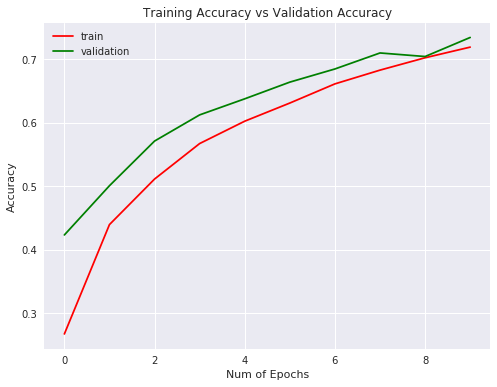

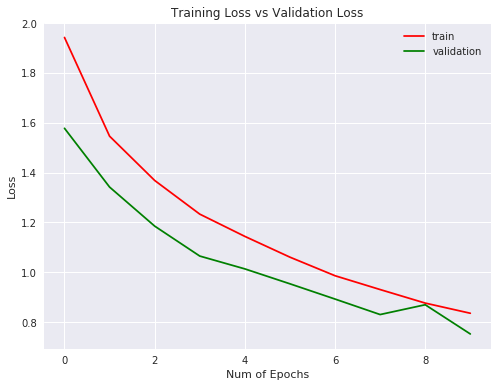

In [47]:
nn(model_3_avg(), save='cifar_cnn_3_avg.h5')

In [48]:
from keras.layers import Input, Concatenate
from keras.models import Model

In [59]:
inputs = Input(shape=(x_train[1,:].shape))

a = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
a = Conv2D(32, (3, 3), activation='relu')(a)
a = MaxPooling2D(pool_size=(2, 2))(a)
a = Dropout(0.25)(a)

a = Conv2D(64, (3, 3), activation='relu', padding='same')(a)
a = Conv2D(64, (3, 3), activation='relu')(a)
a = MaxPooling2D(pool_size=(2, 2))(a)
a = Dropout(0.25)(a)

a = Conv2D(128, (3, 3), activation='relu', padding='same')(a)
a = Conv2D(64, (3, 3), activation='relu')(a)
a = MaxPooling2D(pool_size=(2, 2))(a)
a = Dropout(0.25)(a)

a = Flatten()(a)

b = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
b = Conv2D(32, (5, 5), activation='relu')(b)
b = MaxPooling2D(pool_size=(3, 3))(b)
b = Dropout(0.25)(b)

b = Conv2D(64, (5, 5), activation='relu', padding='same')(b)
b = Conv2D(32, (5, 5), activation='relu')(b)
b = MaxPooling2D(pool_size=(3, 3))(b)
b = Dropout(0.25)(b)

b = Flatten()(b)

common = Concatenate()([a, b])

common = Dense(128, activation='relu')(common)
common = Dense(64, activation='relu')(common)
common = Dropout(0.5)(common)

predictions = Dense(num_classes, activation='softmax')(common)

complex_model = Model(inputs=inputs, outputs=predictions)

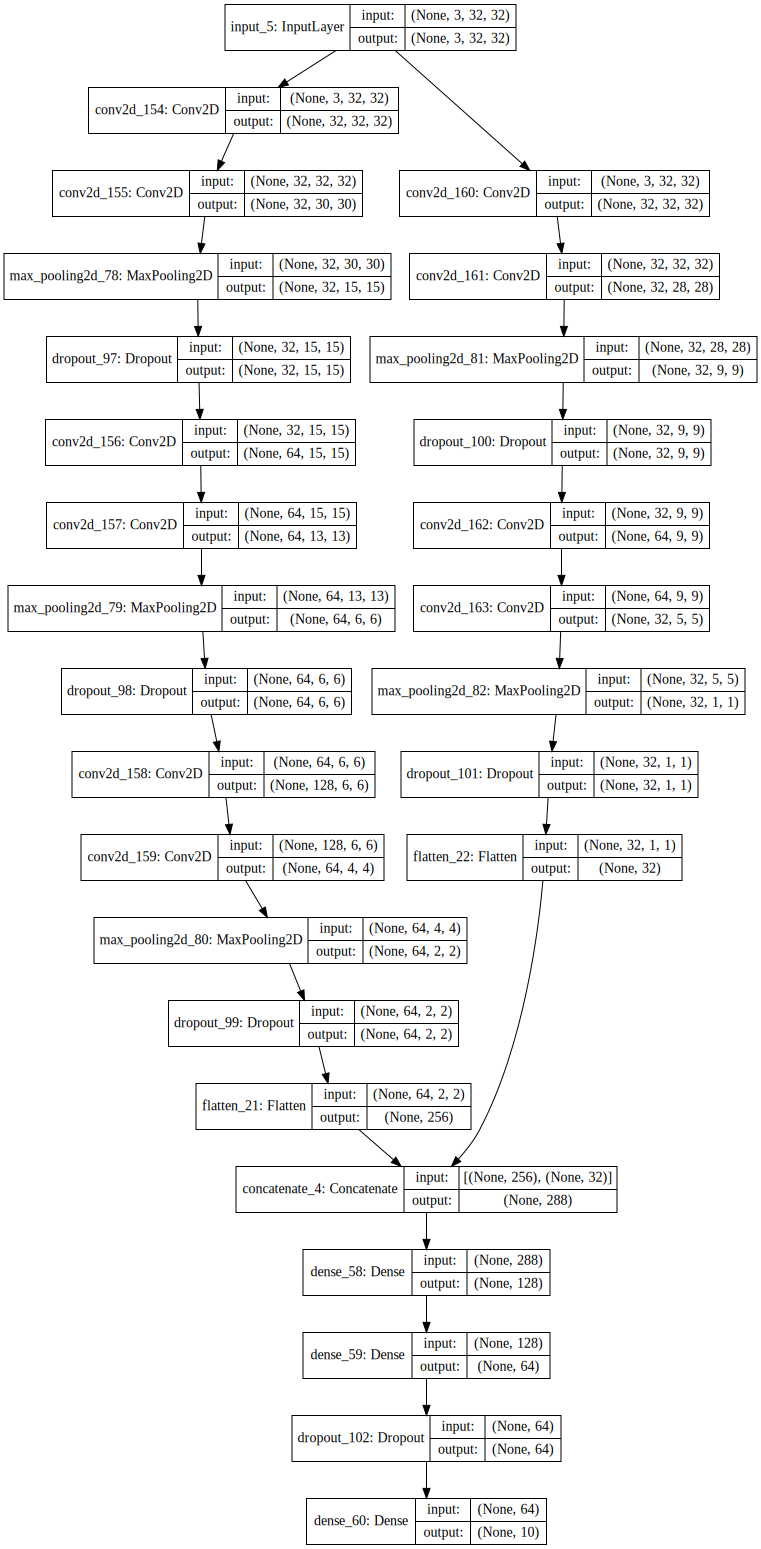

In [60]:
SVG(model_to_dot(complex_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg',))

In [61]:
complex_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 3, 32, 32)    0                                            
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, 32, 32, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_155 (Conv2D)             (None, 32, 30, 30)   9248        conv2d_154[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_78 (MaxPooling2D) (None, 32, 15, 15)   0           conv2d_155[0][0]                 
__________________________________________________________________________________________________
dropout_97

In [63]:
complex_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

In [64]:
history = train(complex_model, batch_size, 20)
my_eval(model, history)
complex_model.save('cifar_cnn_complex.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 32s 641us/step - loss: 1.8670 - acc: 0.2922 - val_loss: 1.4801 - val_acc: 0.4731
Epoch 2/20
50000/50000 [==============================] - 32s 632us/step - loss: 1.4586 - acc: 0.4743 - val_loss: 1.2252 - val_acc: 0.5624
Epoch 3/20
50000/50000 [==============================] - 32s 634us/step - loss: 1.2756 - acc: 0.5500 - val_loss: 1.0591 - val_acc: 0.6230
Epoch 4/20
50000/50000 [==============================] - 32s 634us/step - loss: 1.1562 - acc: 0.5969 - val_loss: 0.9897 - val_acc: 0.6490
Epoch 5/20
50000/50000 [==============================] - 32s 634us/step - loss: 1.0679 - acc: 0.6309 - val_loss: 0.9677 - val_acc: 0.6573
Epoch 6/20
50000/50000 [==============================] - 32s 634us/step - loss: 0.9946 - acc: 0.6586 - val_loss: 0.8687 - val_acc: 0.7028
Epoch 7/20
50000/50000 [==============================] - 32s 634us/step - loss: 0.9348 - acc: 0.6795 - val_loss: 0.

NameError: name 'model' is not defined

In [65]:
complex_model.save('cifar_cnn_complex.h5')

In [66]:
! ls -lh

total 46M
-rw-r--r-- 1 valentin valentin 2,2K Dec  6 16:09 backup_ecm.txt
-rw-r--r-- 1 valentin valentin 4,3M Feb 11 22:44 cifar_cnn_3_avg.h5
-rw-r--r-- 1 valentin valentin 4,3M Feb 11 22:24 cifar_cnn_3.h5
-rw-r--r-- 1 valentin valentin 2,0M Feb 11 20:26 cifar_cnn_base.h5
-rw-r--r-- 1 valentin valentin 4,6M Feb 11 23:13 cifar_cnn_complex.h5
-rw-r--r-- 1 valentin valentin 2,9M Feb 11 22:38 cifar_cnn_deeper.h5
-rw-r--r-- 1 valentin valentin 532K Feb 11 23:13 CIFAR_cnn.ipynb
-rw-r--r-- 1 valentin valentin 4,3M Feb 11 22:21 cifar_cnn_padded.h5
-rw-r--r-- 1 valentin valentin 1,1M Feb 11 20:14 CIFAR_feed_forward.ipynb
-rw-r--r-- 1 valentin valentin 3,5M Feb 10 18:22 cifar_v1_1000ep.h5
-rw-r--r-- 1 valentin valentin 3,5M Feb 10 23:24 cifar_v1_100ep.h5
-rw-r--r-- 1 valentin valentin 2,0M Feb 11 16:27 cifar_v2.h5
-rw-r--r-- 1 valentin valentin 2,1M Feb 11 16:29 cifar_v3.h5
-rw-r--r-- 1 valentin valentin 2,0M Feb 11 16:33 cifar_v4.h5
-rw-r--r-- 1 valentin valentin 2,0M Feb 11 16:35 cifar_v5.h5
-

Test loss: 0.6840794985771179
Test accuracy: 0.7754


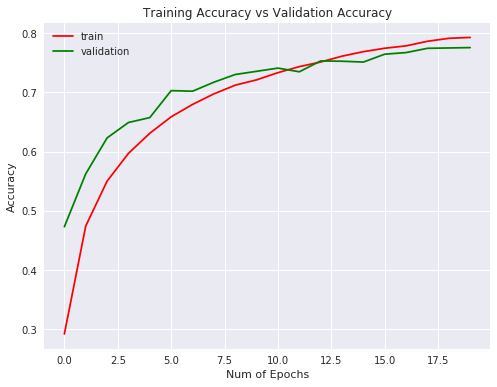

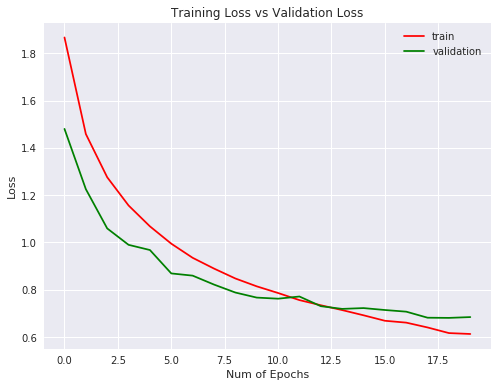

In [67]:
my_eval(complex_model, history)

In [69]:
model_best = load_model('cifar_cnn_3.h5')
model_best

In [72]:
model_best.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 30, 30)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 15, 15)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 15, 15)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 13, 13)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 6, 6)          0         
__________

In [74]:
from keras.layers import Model

In [76]:
layer_name = 'dense_17'

intermediate_model = Model(inputs=model_best.input,
                           outputs=model_best.get_layer(layer_name).output)

In [79]:
x_train[0].shape

(3, 32, 32)

In [83]:
%matplotlib inline

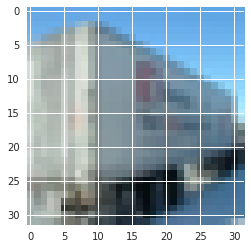

In [93]:
plt.imshow(np.transpose(x_train[15],(1,2,0)))

In [88]:
x_train[:1000].shape

(1000, 3, 32, 32)

In [89]:
intermidiate_output = intermediate_model.predict(x_train[:1000])

In [90]:
intermidiate_output.shape

(1000, 64)

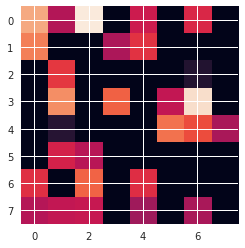

In [94]:
plt.imshow(intermidiate_output[15].reshape(8,8))

In [95]:
from sklearn.metrics.pairwise import cosine_similarity

In [111]:
diff_ind = 0
diff_val = cosine_similarity(X=intermidiate_output[0].reshape(1, -1), Y=intermidiate_output[15].reshape(1, -1))
for i in range(100):
    diff = cosine_similarity(X=intermidiate_output[16 + i].reshape(1, -1), Y=intermidiate_output[15].reshape(1, -1))
    if diff > diff_val:
        diff_val = diff
        diff_ind = i
        


In [115]:
diff_ind

0

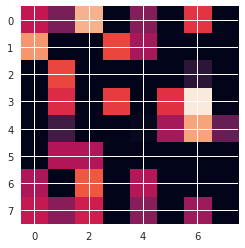

In [116]:
plt.imshow(intermidiate_output[16].reshape(8,8))

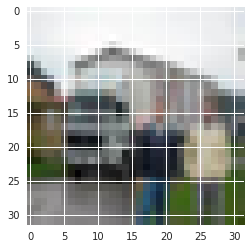

In [117]:
plt.imshow(np.transpose(x_train[16],(1,2,0)))

In [138]:
indexes = []
for i in range(10):
    indexes.append(np.random.randint(10000)) 
indexes

[6777, 6939, 7833, 7575, 5602, 6930, 9663, 8974, 7671, 7553]

In [121]:
intermidiate_output = intermediate_model.predict(x_train)

In [139]:

found = []

for j in range(10):
    
    current_img = indexes[j]
    
    diff_ind = 0
    diff_val = cosine_similarity(X=intermidiate_output[10000].reshape(1, -1), Y=intermidiate_output[j].reshape(1, -1))
    for i in range(40000):
        diff = cosine_similarity(X=intermidiate_output[10000 + i].reshape(1, -1), Y=intermidiate_output[j].reshape(1, -1))
        if diff > diff_val:
            diff_val = diff
            diff_ind = i
            
    found.append((j, diff_ind, diff_val))

found

[(0, 30587, array([[0.9774116]], dtype=float32)),
 (1, 38921, array([[0.99638516]], dtype=float32)),
 (2, 27824, array([[0.99729013]], dtype=float32)),
 (3, 38216, array([[0.9947628]], dtype=float32)),
 (4, 20104, array([[0.9987415]], dtype=float32)),
 (5, 20050, array([[0.99452555]], dtype=float32)),
 (6, 31136, array([[0.9942911]], dtype=float32)),
 (7, 15811, array([[0.9996258]], dtype=float32)),
 (8, 18279, array([[0.9982281]], dtype=float32)),
 (9, 29287, array([[0.99047554]], dtype=float32))]

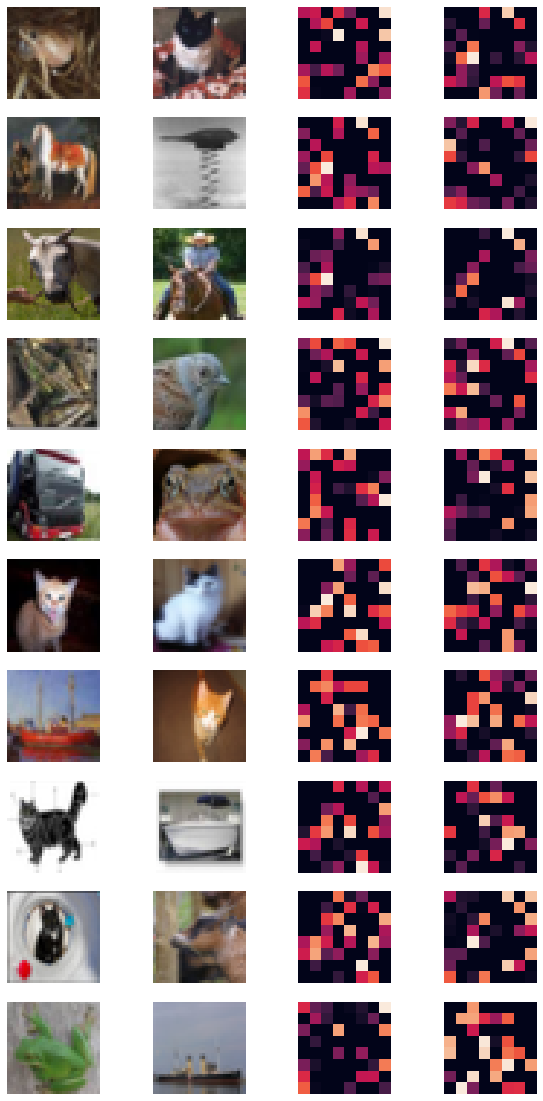

In [147]:
fig = plt.figure(figsize=(10, 20))

for i,similar, val in found:
# i, similar, val = found[0]
    
    ax = fig.add_subplot(10, 4, 1 + i * 4, xticks=[], yticks=[])
    im = np.transpose(x_train[indexes[i]],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 4, 2 + i * 4, xticks=[], yticks=[])
    im = np.transpose(x_train[similar],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 4, 3 + i * 4, xticks=[], yticks=[])
    plt.imshow(intermidiate_output[indexes[i]].reshape(8,8))


    ax = fig.add_subplot(10, 4, 4 + i * 4, xticks=[], yticks=[])
    plt.imshow(intermidiate_output[similar].reshape(8,8))

#     print(cosine_similarity(X=intermidiate_output[indexes[i]].reshape(1, -1), Y=intermidiate_output[similar].reshape(1, -1)))    
#     print(i)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_164 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 32, 30, 30)        9248      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 32, 15, 15)        0         
_________________________________________________________________
dropout_103 (Dropout)        (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 64, 15, 15)        18496     
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 64, 13, 13)        36928     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 64, 6, 6)          0         
__________

50000/50000 [==============================] - 19s 388us/step - loss: 0.5075 - acc: 0.8355 - val_loss: 0.6138 - val_acc: 0.8073
Epoch 27/30
50000/50000 [==============================] - 19s 389us/step - loss: 0.5016 - acc: 0.8318 - val_loss: 0.6130 - val_acc: 0.8066
Epoch 28/30
50000/50000 [==============================] - 19s 388us/step - loss: 0.4875 - acc: 0.8365 - val_loss: 0.6415 - val_acc: 0.8024
Epoch 29/30
50000/50000 [==============================] - 19s 389us/step - loss: 0.4886 - acc: 0.8376 - val_loss: 0.6081 - val_acc: 0.8095
Epoch 30/30
50000/50000 [==============================] - 19s 389us/step - loss: 0.4773 - acc: 0.8426 - val_loss: 0.6267 - val_acc: 0.8069
Test loss: 0.626748216342926
Test accuracy: 0.8069


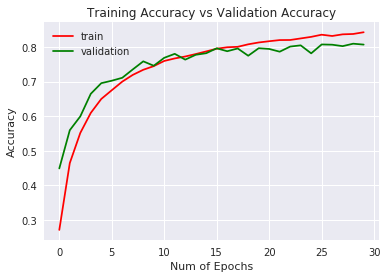

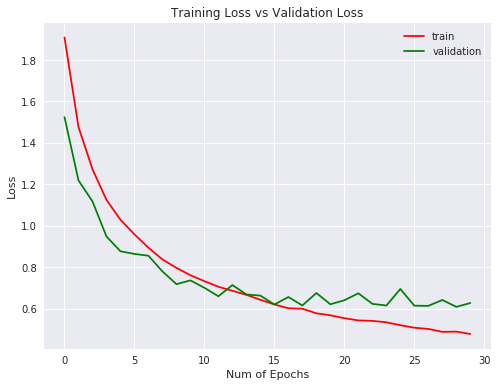

In [148]:
model3_30ep = nn(model_3(), epochs=30, save='cifar_cnn_3_30ep')

In [150]:
intermediate_model_new = Model(inputs=model3_30ep.input,
                               outputs=model3_30ep.get_layer('dense_62').output)

AttributeError: 'NoneType' object has no attribute 'input'

In [153]:
model3_30ep = load_model('cifar_cnn_3_30ep')
model3_30ep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_164 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 32, 30, 30)        9248      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 32, 15, 15)        0         
_________________________________________________________________
dropout_103 (Dropout)        (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 64, 15, 15)        18496     
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 64, 13, 13)        36928     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 64, 6, 6)          0         
__________

In [154]:
intermediate_model_new = Model(inputs=model3_30ep.input,
                               outputs=model3_30ep.get_layer('dense_62').output)

In [155]:
intermidiate_output_new = intermediate_model_new.predict(x_train[:1000])

In [156]:
intermidiate_output_new.shape

(1000, 64)

In [157]:
sim = cosine_similarity(intermidiate_output_new)

In [160]:
sim.shape

(1000, 1000)

In [165]:
np.ones((1000,1000), dtype=np.float32).shape

(1000, 1000)

In [217]:
sim_modified = sim.copy()

In [218]:
np.fill_diagonal(sim_modified, 0)
sim_modified

array([[0.        , 0.22739363, 0.07732554, ..., 0.2554208 , 0.3227995 ,
        0.76078814],
       [0.22739363, 0.        , 0.8001181 , ..., 0.6306739 , 0.512418  ,
        0.2538741 ],
       [0.07732554, 0.8001181 , 0.        , ..., 0.45217845, 0.33829322,
        0.13330224],
       ...,
       [0.2554208 , 0.6306739 , 0.45217845, ..., 0.        , 0.27307773,
        0.28128517],
       [0.3227995 , 0.512418  , 0.33829322, ..., 0.27307773, 0.        ,
        0.35312575],
       [0.76078814, 0.2538741 , 0.13330224, ..., 0.28128517, 0.35312575,
        0.        ]], dtype=float32)

In [219]:
from numpy import unravel_index

copy = sim_modified.copy()

top = []

for i in range(10):
    ind = unravel_index(copy.argmax(), copy.shape)
    top.append(ind)
    a, b = ind
    copy[(a, b)] -= 1
    copy[(b, a)] -= 1
    
top

[(278, 666),
 (45, 176),
 (176, 834),
 (43, 412),
 (176, 226),
 (596, 880),
 (126, 323),
 (45, 834),
 (164, 228),
 (201, 226)]

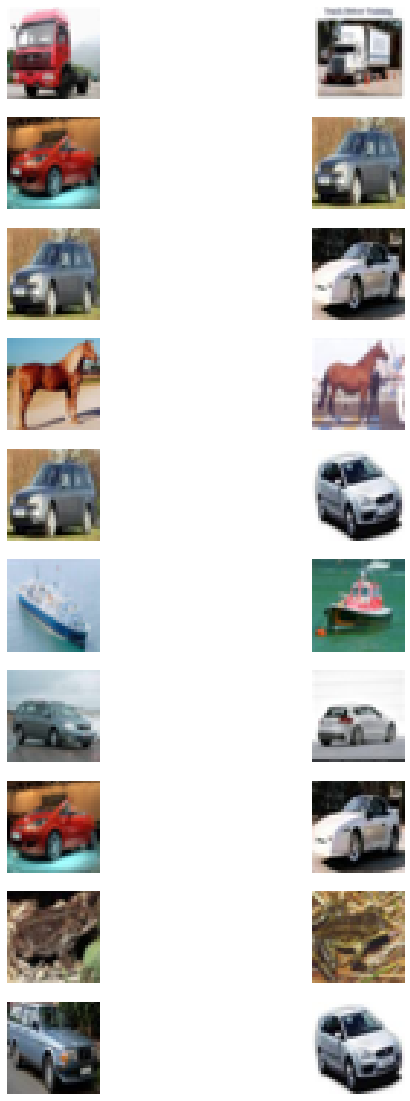

In [220]:
fig = plt.figure(figsize=(10, 20))

i = 0

for a,b in top:
    
    ax = fig.add_subplot(10, 2, 1 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[a],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 2, 2 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[b],(1,2,0))
    plt.imshow(im)
    
    i += 1

plt.show()

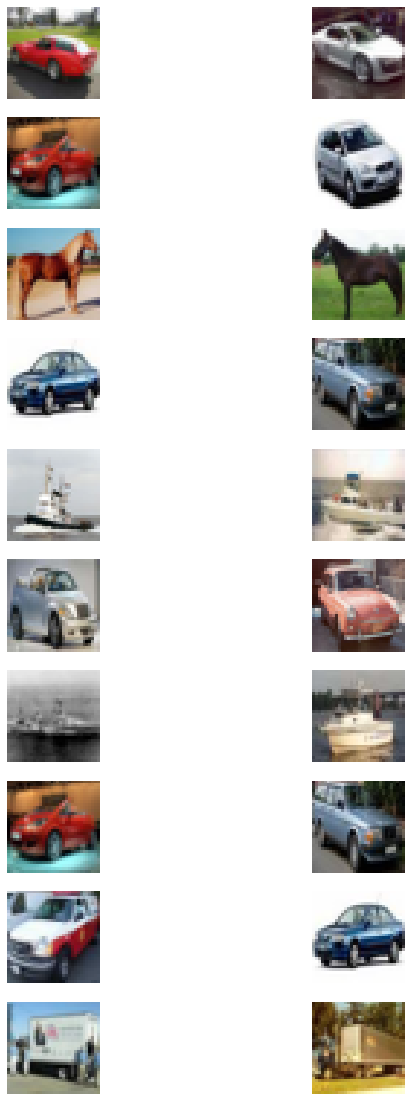

In [221]:
top = []

for i in range(10):
    ind = unravel_index(copy.argmax(), copy.shape)
    top.append(ind)
    a, b = ind
    copy[(a, b)] -= 1
    copy[(b, a)] -= 1
    
fig = plt.figure(figsize=(10, 20))

i = 0

for a,b in top:
    
    ax = fig.add_subplot(10, 2, 1 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[a],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 2, 2 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[b],(1,2,0))
    plt.imshow(im)
    
    i += 1

plt.show()


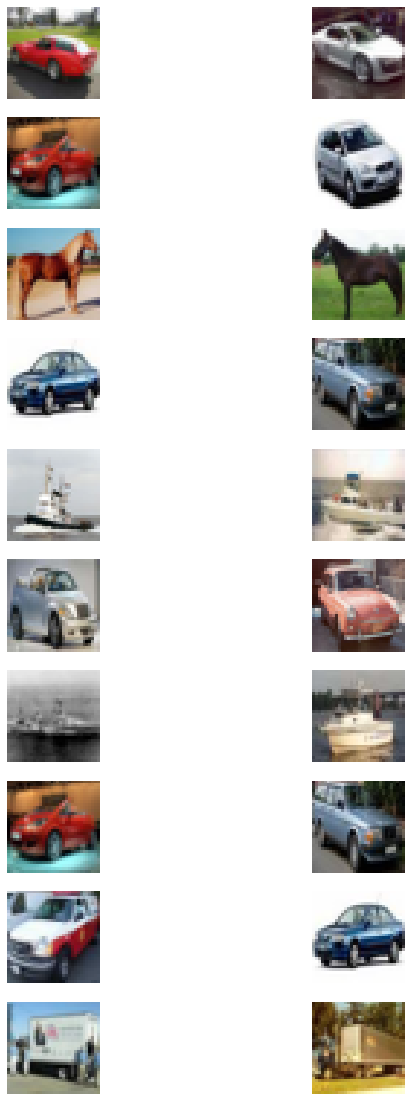

In [222]:
fig = plt.figure(figsize=(10, 20))

i = 0

for a,b in top:
    
    ax = fig.add_subplot(10, 2, 1 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[a],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 2, 2 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[b],(1,2,0))
    plt.imshow(im)
    
    i += 1

plt.show()

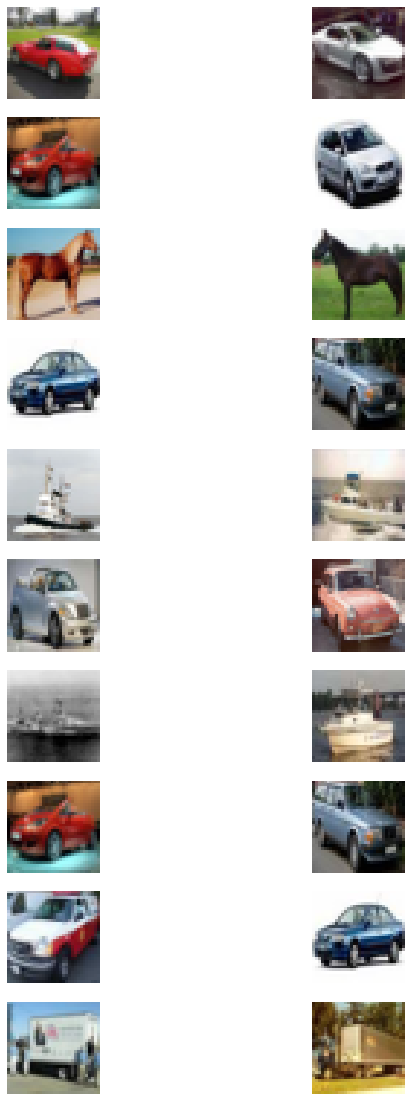

In [223]:
fig = plt.figure(figsize=(10, 20))

i = 0

for a,b in top:
    
    ax = fig.add_subplot(10, 2, 1 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[a],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 2, 2 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[b],(1,2,0))
    plt.imshow(im)
    
    i += 1

plt.show()

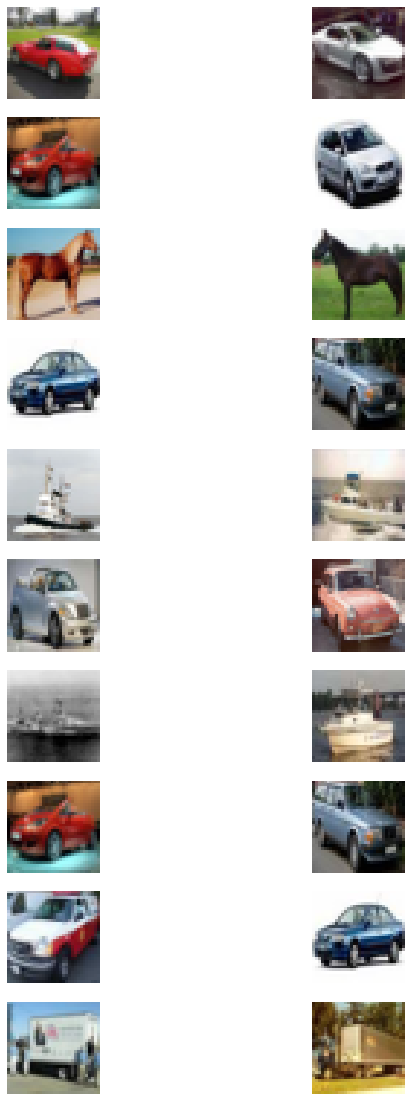

In [224]:
fig = plt.figure(figsize=(10, 20))

i = 0

for a,b in top:
    
    ax = fig.add_subplot(10, 2, 1 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[a],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 2, 2 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[b],(1,2,0))
    plt.imshow(im)
    
    i += 1

plt.show()

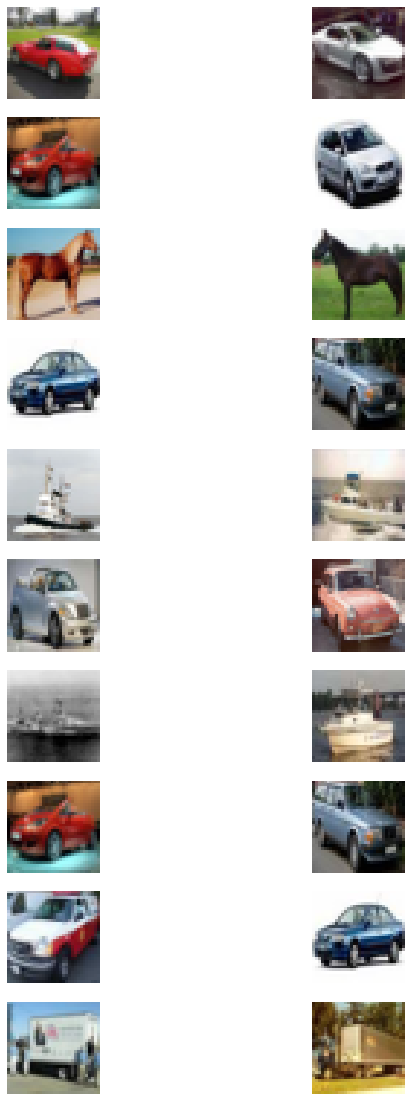

In [225]:
fig = plt.figure(figsize=(10, 20))

i = 0

for a,b in top:
    
    ax = fig.add_subplot(10, 2, 1 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[a],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 2, 2 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[b],(1,2,0))
    plt.imshow(im)
    
    i += 1

plt.show()

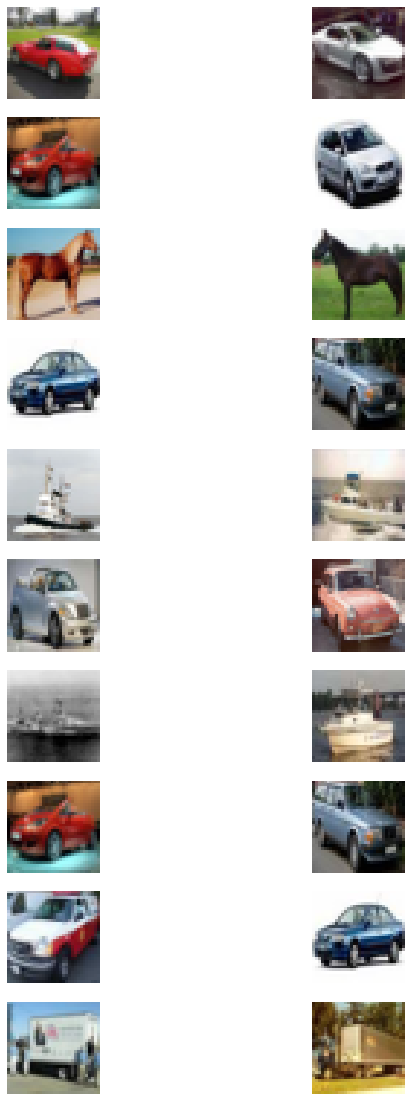

In [226]:
fig = plt.figure(figsize=(10, 20))

i = 0

for a,b in top:
    
    ax = fig.add_subplot(10, 2, 1 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[a],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 2, 2 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[b],(1,2,0))
    plt.imshow(im)
    
    i += 1

plt.show()

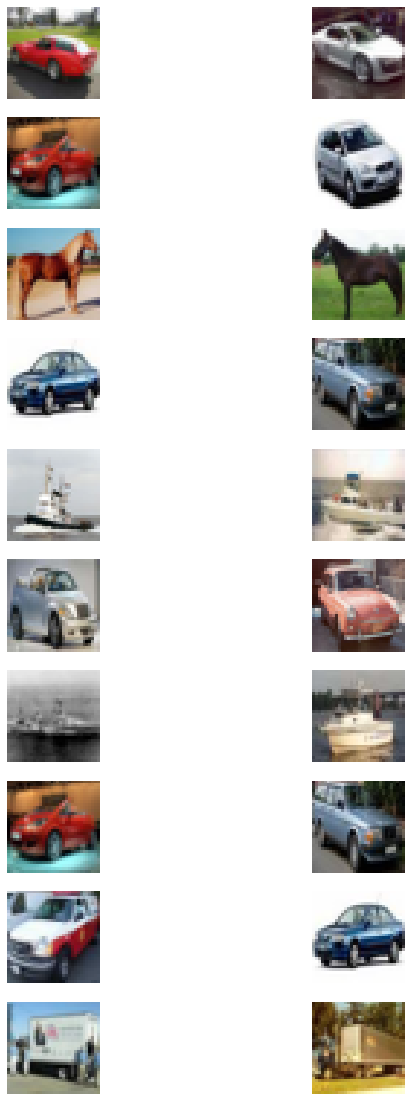

In [227]:
fig = plt.figure(figsize=(10, 20))

i = 0

for a,b in top:
    
    ax = fig.add_subplot(10, 2, 1 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[a],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 2, 2 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[b],(1,2,0))
    plt.imshow(im)
    
    i += 1

plt.show()

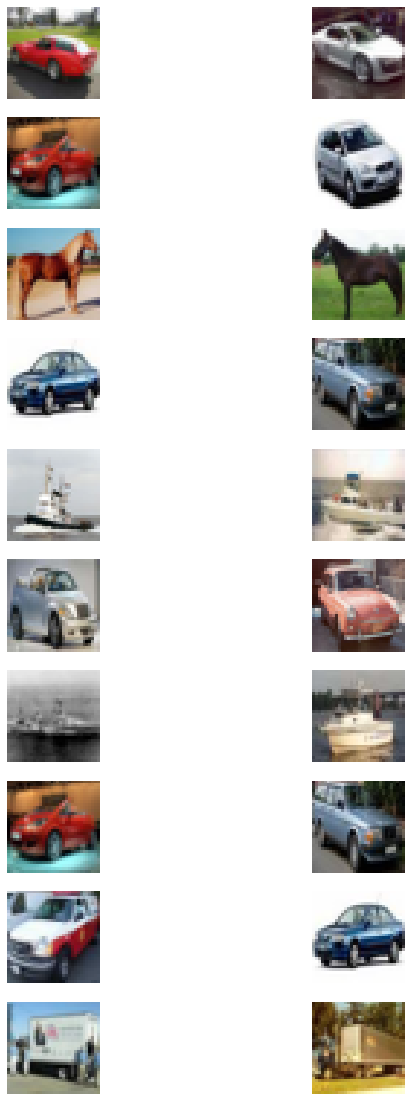

In [228]:
fig = plt.figure(figsize=(10, 20))

i = 0

for a,b in top:
    
    ax = fig.add_subplot(10, 2, 1 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[a],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 2, 2 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[b],(1,2,0))
    plt.imshow(im)
    
    i += 1

plt.show()

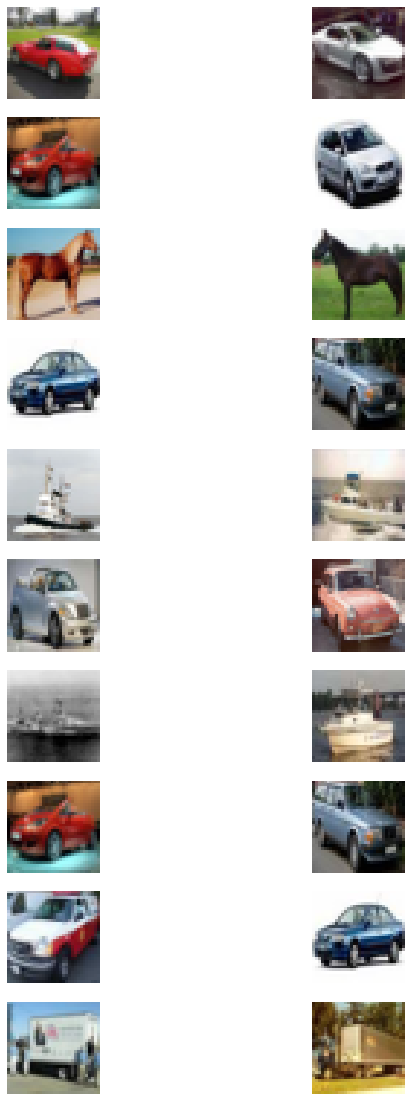

In [229]:
fig = plt.figure(figsize=(10, 20))

i = 0

for a,b in top:
    
    ax = fig.add_subplot(10, 2, 1 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[a],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 2, 2 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[b],(1,2,0))
    plt.imshow(im)
    
    i += 1

plt.show()

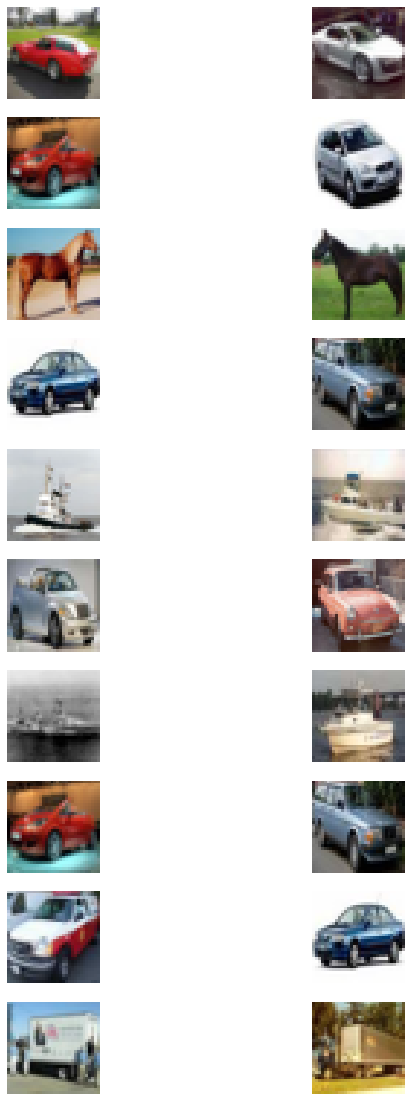

In [230]:
fig = plt.figure(figsize=(10, 20))

i = 0

for a,b in top:
    
    ax = fig.add_subplot(10, 2, 1 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[a],(1,2,0))
    plt.imshow(im)

    ax = fig.add_subplot(10, 2, 2 + i * 2, xticks=[], yticks=[])
    im = np.transpose(x_train[b],(1,2,0))
    plt.imshow(im)
    
    i += 1

plt.show()